# LLM Caching

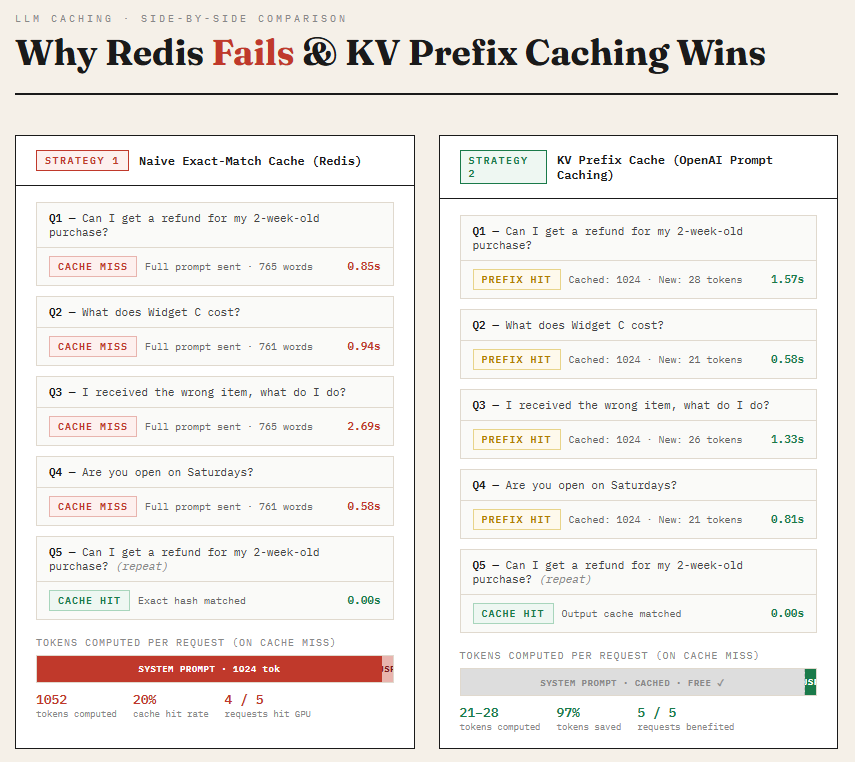

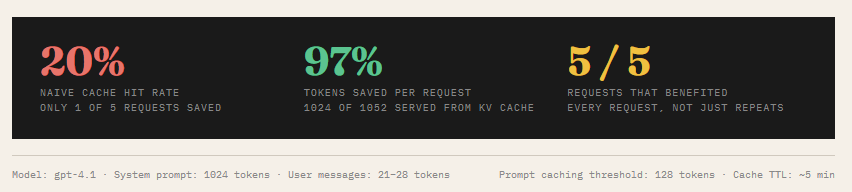

## Setting up dependencies

In [1]:
import hashlib
import time
from openai import OpenAI
from getpass import getpass
import os

os.environ['OPENAI_API_KEY'] = getpass('Enter OpenAI API Key: ')

Enter OpenAI API Key: ··········


## System Prompt
The system prompt in this example is deliberately long to simulate a real-world production setup. In enterprise applications like customer support bots, legal assistants, or internal copilots, the system prompt often contains detailed company policies, product catalogs, shipping rules, refund terms, escalation instructions, and predefined FAQs. All of this context must be included in every request to ensure the model behaves consistently and provides accurate responses.

Even if a user asks a very short question like “What’s the price of Widget B?”, the model still has to process the entire system prompt first. This pre-fill phase—where the model computes attention over all those tokens—is the most expensive part of inference. In practice, most tokens in a request are static (system instructions and reference content), while only a small portion comes from the user

In [7]:
client = OpenAI()
SYSTEM_PROMPT = """You are a helpful customer support assistant for AcmeCorp, a company that sells high-quality widgets and accessories.
Your job is to assist customers with questions about products, orders, refunds, shipping, and general support. Always be polite, clear, and concise.
If a question falls outside your knowledge, escalate to a human agent by saying "I'll connect you with a human agent for that."

=== COMPANY POLICY ===
- Refunds are accepted within 30 days of purchase, no questions asked.
- After 30 days, refunds are considered on a case-by-case basis by the returns team.
- Exchanges are accepted within 45 days of purchase.
- Items must be returned in original packaging where possible, but this is not a hard requirement.
- Refunds are processed within 5-7 business days of receiving the returned item.
- Shipping costs are non-refundable unless the return is due to our error (wrong item, defective product).
- Customers are responsible for return shipping costs unless the item arrived damaged or incorrect.

=== PRODUCT CATALOG ===
Widget A — $10
  - Entry-level widget, suitable for home use.
  - Available in red, blue, and black.
  - 1-year manufacturer warranty.
  - Ships within 2 business days.

Widget B — $25
  - Mid-range widget with enhanced durability.
  - Available in silver and black.
  - 2-year manufacturer warranty.
  - Compatible with all AcmeCorp accessories.
  - Ships within 2 business days.

Widget C — $50
  - Premium widget, commercial-grade.
  - Available in black only.
  - 3-year manufacturer warranty.
  - Includes free priority shipping.
  - Recommended for heavy daily use.

Accessory Pack — $8
  - Compatible with Widget B and Widget C.
  - Includes cleaning kit, carry case, and spare parts.

Extended Warranty — $15/year
  - Available for all products.
  - Covers accidental damage and manufacturer defects.
  - Can be purchased up to 60 days after product purchase.

=== SHIPPING POLICY ===
- Standard shipping: 5-7 business days, $4.99 flat rate.
- Express shipping: 2-3 business days, $12.99 flat rate.
- Priority shipping: 1-2 business days, $19.99 flat rate (free for Widget C).
- International shipping: available to 30 countries, rates vary by destination.
- Orders over $75 qualify for free standard shipping.
- Orders are processed Monday-Friday. Orders placed after 3pm EST ship the next business day.
- A tracking number is emailed within 24 hours of shipment.

=== SUPPORT HOURS ===
- Monday to Friday: 9am - 6pm EST.
- Saturday and Sunday: closed.
- Public holidays: closed. A list of observed holidays is on our website.
- Average response time during business hours: under 2 hours.
- After-hours inquiries will be responded to on the next business day.

=== COMMON Q&A ===
Q: How do I return a product?
A: Initiate a return by emailing returns@acmecorp.com with your order number. We will send a prepaid label if the return is due to our error, otherwise you cover the shipping cost.

Q: What is the price of Widget B?
A: Widget B is $25. It comes with a 2-year warranty and is available in silver and black.

Q: Are you open on weekends?
A: No, our support team is available Monday-Friday, 9am-6pm EST.

Q: My item arrived damaged, what do I do?
A: We're sorry to hear that. Please email support@acmecorp.com with your order number and a photo of the damage. We will send a replacement or issue a full refund at no cost to you.

Q: Can I change my order after placing it?
A: Orders can be modified within 1 hour of placement by contacting support. After that, the order may have already been processed for shipping.

Q: Do you offer bulk discounts?
A: Yes, orders of 10 or more units qualify for a 10% discount. Orders of 25 or more units qualify for 20%. Contact our sales team at sales@acmecorp.com for custom quotes.

Q: How do I track my order?
A: A tracking number is sent to your email within 24 hours of shipment. You can also log into your account on our website and view order status under "My Orders".

Q: Is the extended warranty worth it?
A: The extended warranty covers accidental damage and defects beyond the standard manufacturer warranty. It is recommended for Widget C users who rely on it daily.

Q: Can I buy an accessory pack separately?
A: Yes, the Accessory Pack is available for $8 and is compatible with Widget B and Widget C.

Q: What countries do you ship to?
A: We ship to 30 countries. Please visit our website's shipping page for the full list and international rates."""

## Strategy 1: Naive Exact-Match Cache
This is the approach most engineers instinctively reach for when thinking about LLM caching. We concatenate the system prompt and the user message into a single string, generate a SHA-256 hash from it, and use that hash as the cache key in a simple dictionary. If the exact same combined prompt has been seen before, we return the stored response instantly without calling the API. Otherwise, we send the full prompt to the model and cache the result for future use.

At first glance, this seems correct and efficient. But the flaw lies in how the cache key is constructed. Because it includes both the system prompt and the user message, even a tiny variation in wording — a different sentence structure, punctuation change, or extra word — produces a completely different hash. That means a cache miss. In real-world systems, users rarely phrase questions identically, so exact string matches are uncommon. As a result, this naive cache almost never fires, and the model ends up recomputing the same large system prompt tokens from scratch on nearly every request — burning compute without delivering meaningful savings.

In [18]:
naive_cache = {}

def ask_with_naive_cache(user_message: str) -> str:
    # Hash the full prompt (system + user) as the cache key
    full_prompt = SYSTEM_PROMPT + user_message
    cache_key = hashlib.sha256(full_prompt.encode()).hexdigest()

    if cache_key in naive_cache:
        print(f"  [CACHE HIT]  Returning stored response")
        return naive_cache[cache_key]

    # Cache miss — send the entire prompt to the API
    print(f"  [CACHE MISS] Sending full prompt to API ({len(full_prompt.split())} words)")
    response = client.chat.completions.create(
        model="gpt-4.1",
        messages=[
            {"role": "system", "content": SYSTEM_PROMPT},
            {"role": "user",   "content": user_message}
        ]
    )
    result = response.choices[0].message.content
    naive_cache[cache_key] = result
    return result

## Strategy 2: KV Prefix Cache
This is the approach that actually works at scale. The key difference starts at the very first line — we only hash the user message to build the cache key, not the system prompt, because the system prompt never changes. If the exact user message has been seen before, we return the stored response immediately. For everything else, we still send the same request to the API, but this is where OpenAI's prompt caching kicks in behind the scenes.

Because our system prompt is identical across every request and long enough to cross the caching threshold, OpenAI's inference servers recognize the shared prefix and reuse the previously computed attention states (KV tensors) for those tokens instead of recomputing them. We surface this by reading prompt_tokens_details.cached_tokens from the API response, which tells us exactly how many tokens were served from cache versus freshly computed.

In our output we saw Cached: 1024 | New: 21-28 on every request — meaning the model only did real work on the handful of tokens that made up the user's question, while the entire 1024-token system prompt was free. This saving applies to every unique request, not just repeated ones, which is what makes it fundamentally more powerful than the naive approach.

In [17]:
output_cache = {}

def ask_with_prefix_cache(user_message: str) -> str:
    # Only hash the user message — the system prompt is always the same
    cache_key = hashlib.sha256(user_message.encode()).hexdigest()

    if cache_key in output_cache:
        print(f"  [CACHE HIT]  Returning stored response")
        return output_cache[cache_key]

    # Cache miss — but OpenAI will reuse the cached KV state
    # for our system prompt on their inference servers (prompt caching).
    # We only "pay" the compute cost for the new user message tokens.
    print(f"  [PREFIX HIT] System prompt cached. Only processing: '{user_message}'")
    response = client.chat.completions.create(
        model="gpt-4.1",
        messages=[
            {"role": "system", "content": SYSTEM_PROMPT},
            {"role": "user",   "content": user_message}
        ]
    )

    # Check if OpenAI actually used its prompt cache
    usage = response.usage
    cached_tokens = getattr(usage.prompt_tokens_details, "cached_tokens", 0)
    print(f"  [TOKENS]     Total: {usage.prompt_tokens} | Cached: {cached_tokens} | New: {usage.prompt_tokens - cached_tokens}")

    result = response.choices[0].message.content
    output_cache[cache_key] = result
    return result


## Running the Demo
In this demo, we compare both caching strategies using the same five questions. The setup is intentional: four different questions followed by one exact repeat of the first question. This helps highlight where the naive approach fails.

With the naive cache, the first four questions are all cache misses. Even if they are similar in meaning, they are phrased differently, so their hashes don’t match. Only the fifth question — which is an exact repeat — results in a cache hit.

The prefix-based approach behaves differently. It also shows cache misses for the first four questions at the output level. However, it is still saving compute on every request because the system prompt’s KV state is being reused internally. So even though the responses are new, the expensive system prompt tokens are not being recomputed each time.

We measure latency using time.time() before and after each request to show the performance difference, and we shorten the output to keep it readable.

For the fifth question, both caches return instantly — but for different reasons. The naive cache works only because the entire prompt matches exactly. The prefix cache works because the user message matches in our smaller output cache. More importantly, the prefix method was already saving compute on every request — even before any exact repeat occurred.

In [8]:
def run_demo():
    # These are all different messages — no exact repeats.
    # The naive cache will miss on all of them.
    # The prefix cache will reuse the system prompt for all of them.
    questions = [
        "Can I get a refund for my 2-week-old purchase?",
        "What does Widget C cost?",
        "I received the wrong item, what do I do?",
        "Are you open on Saturdays?",
        "Can I get a refund for my 2-week-old purchase?",  # exact repeat — both caches hit
    ]

    print("=" * 60)
    print("STRATEGY 1: Naive Exact-Match Cache")
    print("=" * 60)
    for q in questions:
        print(f"\nQ: {q}")
        t0 = time.time()
        answer = ask_with_naive_cache(q)
        print(f"  A: {answer[:80]}...")
        print(f"  Time: {time.time() - t0:.2f}s")

    print("\n")
    print("=" * 60)
    print("STRATEGY 2: KV Prefix Cache")
    print("=" * 60)
    for q in questions:
        print(f"\nQ: {q}")
        t0 = time.time()
        answer = ask_with_prefix_cache(q)
        print(f"  A: {answer[:80]}...")
        print(f"  Time: {time.time() - t0:.2f}s")


## Comparing the Results
The output clearly shows the difference between output-level caching and compute-level caching. In the naive strategy, the first four questions are full cache misses, meaning the entire 760+ word prompt is sent to the model each time, resulting in normal API latency. Only the fifth question — an exact repeat — produces a cache hit and returns instantly. In contrast, the KV prefix strategy reuses the cached system prompt on every request.

Even though the first four questions are different, 1024 out of ~1050 tokens are served from cache each time, and only the small user message portion (21–28 tokens) is newly processed. This means compute is saved on every single request, not just on exact repeats.

The final repeated question returns instantly in both cases, but the key difference is that the prefix strategy was already saving tokens and reducing compute long before any exact match occurred.

In [19]:
run_demo()

STRATEGY 1: Naive Exact-Match Cache

Q: Can I get a refund for my 2-week-old purchase?
  [CACHE MISS] Sending full prompt to API (765 words)
  A: Yes, you can request a refund for your 2-week-old purchase. We accept refunds wi...
  Time: 0.85s

Q: What does Widget C cost?
  [CACHE MISS] Sending full prompt to API (761 words)
  A: Widget C costs $50. It is a premium, commercial-grade widget available in black ...
  Time: 0.94s

Q: I received the wrong item, what do I do?
  [CACHE MISS] Sending full prompt to API (765 words)
  A: I'm very sorry you received the wrong item. Please email support@acmecorp.com wi...
  Time: 2.69s

Q: Are you open on Saturdays?
  [CACHE MISS] Sending full prompt to API (761 words)
  A: No, our support team is available Monday to Friday, 9am to 6pm EST. We are close...
  Time: 0.58s

Q: Can I get a refund for my 2-week-old purchase?
  [CACHE HIT]  Returning stored response
  A: Yes, you can request a refund for your 2-week-old purchase. We accept refunds wi...